# InspectCare: Using online activity to identify illegal childcare operations

Import packages and define functions.

In [1]:
%matplotlib inline
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en')
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats
import time
import scrapy
import json
import os
import io
from bs4 import BeautifulSoup
import urllib2
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
#from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn import cross_validation
import string
import collections
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from pprint import pprint
import itertools
import seaborn

/Users/MF/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def first_classifier(text):
    if text.lower().count('nanny') | text.lower().count('nannies') | text.lower().count('babysitting') | text.lower().count('sitter'):
        return 'b'
    elif text.lower().count('childcare') | text.lower().count('daycare') | text.lower().count('child care') | text.lower().count('day care'):
        return 'a'
    else:
        return 'c'

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Load all data

In [5]:
city_active_df = pd.read_excel('data/City_Programs.xlsx', skiprows = range(7), sheetname = 0)

city_inactive_df_1 = pd.read_excel('data/City_Programs.xlsx', skiprows = range(9), sheetname = 1)
city_inactive_df_2 = pd.read_excel('data/City_Programs.xlsx', skiprows = range(9), sheetname = 2)

city_inactive_df = pd.concat([city_inactive_df_1, city_inactive_df_2], ignore_index=True)

del [city_inactive_df_1, city_inactive_df_2]

In [6]:
state_df_0 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(7), sheetname = 0) 
state_df_1 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 1) 
state_df_2 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 2)
state_df_3 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 3)
state_df_4 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 4)
state_df_5 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 5)
state_df_6 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 6)
state_df_7 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 7)
state_df_8 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(9), sheetname = 8)
state_df_9 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 9)
state_df_10 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 10)
state_df_11 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 11)
state_df_12 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 12)
state_df_13 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 13)
state_df_14 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 14)
state_df_15 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 15)
state_df_16 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 16)
state_df_17 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 17)
state_df_18 = pd.read_excel('data/State_Programs.xlsx', skiprows = range(8), sheetname = 18)

state_df = pd.concat([state_df_0, state_df_1, state_df_2, state_df_3, state_df_4, state_df_5, 
                      state_df_6, state_df_7, state_df_8, state_df_9, state_df_10, state_df_11, 
                      state_df_12, state_df_13, state_df_14, state_df_15, state_df_16, 
                      state_df_17, state_df_18], ignore_index=True)

del [state_df_0, state_df_1, state_df_2, state_df_3, state_df_4, state_df_5, state_df_6, 
     state_df_7, state_df_8, state_df_9, state_df_10, state_df_11, state_df_12, state_df_13,
     state_df_14, state_df_15, state_df_16, state_df_17, state_df_18]

In [7]:
complaints_df = pd.read_csv('data/complaints2017.csv') #since 1-1-2017

In [8]:
craigs_df1 = pd.read_csv('craigslist/result-jobs-multi-pages-content-FIRST.csv')
craigs_df2 = pd.read_csv('craigslist/result-jobs-multi-pages-content.csv')

craigs_df = pd.concat([craigs_df1, craigs_df2], ignore_index=True)

craigs_df.shape #total number of posts, 4295

del [craigs_df1, craigs_df2]

craigs_df.drop_duplicates(subset = ['Title'], inplace=True)
craigs_df.drop_duplicates(subset = ['Description'], inplace=True)

#Partially labelled craigs_df
ct_df = pd.read_csv('craigslist/craigs_tagged.csv')

tagged_df = ct_df[(ct_df['Class'] == 'a') | (ct_df['Class'] == 'b') | (ct_df['Class'] == 'c')].copy()

In [9]:
craigs_df.shape #total number of posts after dedupe
ct_df.shape #total number of tagged posts

(1144, 6)

In [10]:
tagged_df.reset_index(drop = True, inplace = True)
del tagged_df['Unnamed: 0']
#tagged_df

## Classify Craigslist into 3 categories

In [11]:
tagged_class_amounts = list(tagged_df['Class'].value_counts().values)
tagged_class_amounts

[307, 244, 68]

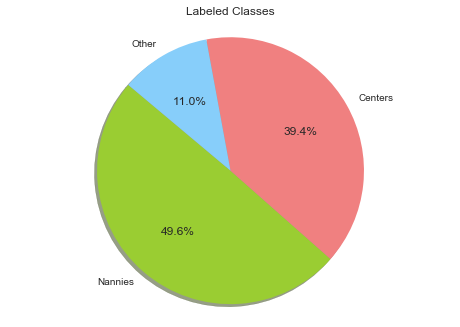

In [12]:
labels = 'Nannies', 'Centers', 'Other'
sizes = tagged_class_amounts
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
 
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Labeled Classes')
 
plt.axis('equal')
plt.show()

### First a simple keyword search

In [13]:
#tagged_df.assign(Key_search = 'z') #only do if haven't made a copy
tagged_df['Key_search'] = 'z'
tagged_df['Key_search'] = tagged_df['Description'].apply(first_classifier)

In [14]:
tagged_df['Key_search'].value_counts()

b    246
a    227
c    146
Name: Key_search, dtype: int64

In [15]:
metrics.accuracy_score(tagged_df['Class'], tagged_df['Key_search'])

0.78190630048465271

In [16]:
cm_keyword = metrics.confusion_matrix(tagged_df['Class'], tagged_df['Key_search'])
print cm_keyword

[[193   6  45]
 [ 23 237  47]
 [ 11   3  54]]


Normalized confusion matrix
[[ 0.79098361  0.02459016  0.18442623]
 [ 0.07491857  0.77198697  0.15309446]
 [ 0.16176471  0.04411765  0.79411765]]


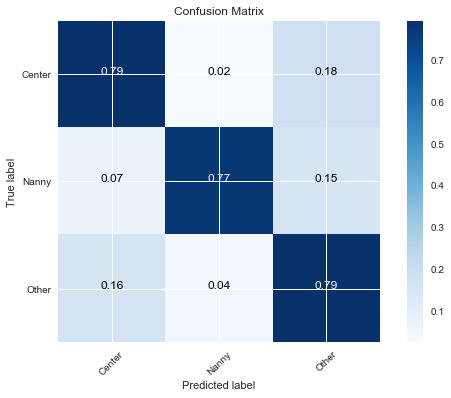

In [17]:
plot_confusion_matrix(cm_keyword, ['Center', 'Nanny', 'Other'], normalize = True)

### Now for Logistic Regression Classifier

In [18]:
cl_target = list(tagged_df['Class'].values) 
cl_data = list(tagged_df['Description'].values)

In [19]:
trial_LR = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'),
                            ngram_range = (1, 3))), #min_df=5,
    ('classifier', LogisticRegression()),
])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(cl_data, cl_target, test_size=0.25, random_state=33)
trial_LR.fit(X_train, y_train)
print trial_LR.score(X_test, y_test)

0.877419354839


In [21]:
scores_LR = cross_val_score(trial_LR, cl_data, cl_target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_LR.mean(), scores_LR.std() * 2))

Accuracy: 0.85 (+/- 0.03)


In [22]:
out_LR = trial_LR.predict(X_train)

In [23]:
cm_LR = metrics.confusion_matrix(y_train, pd.Series(out_LR))
print cm_LR
#might need to test keyword on y_train instead of whole set
#try to cross validate

[[191   2   0]
 [  1 218   0]
 [  9  33  10]]


Normalized confusion matrix
[[ 0.98963731  0.01036269  0.        ]
 [ 0.00456621  0.99543379  0.        ]
 [ 0.17307692  0.63461538  0.19230769]]


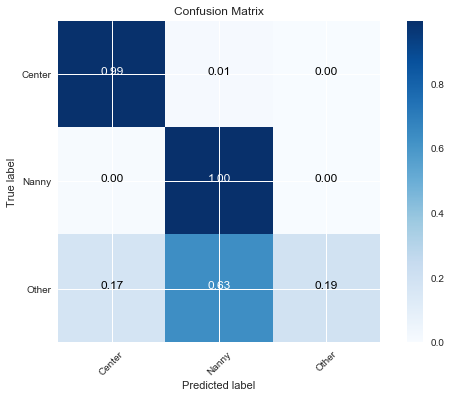

In [24]:
plot_confusion_matrix(cm_LR, ['Center', 'Nanny', 'Other'], normalize = True)

In [25]:
cv_LR = cross_validation.ShuffleSplit(len(cl_data), n_iter=100,
                                   test_size=0.2, random_state=0)

CPU times: user 6.89 s, sys: 868 ms, total: 7.76 s
Wall time: 54.1 s


<module 'matplotlib.pyplot' from '/Users/MF/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

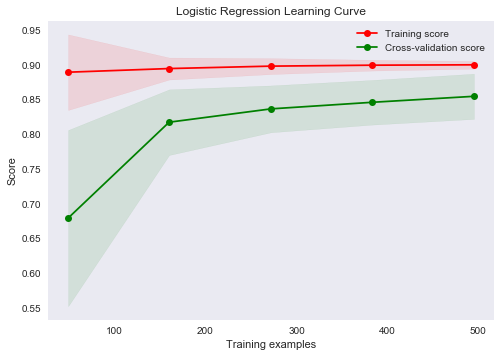

In [26]:
%%time
plot_learning_curve(trial_LR, 'Logistic Regression Learning Curve', cl_data, cl_target, cv=cv_LR, n_jobs=4)

### Also try SVM classifier

In [27]:
trial_SVM = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'),
                             min_df=5, ngram_range = (1, 3))),
    ('classifier', svm.SVC(kernel='linear')),
])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(cl_data, cl_target, test_size=0.25, random_state=33)
trial_SVM.fit(X_train, y_train)
print trial_SVM.score(X_test, y_test)

0.896774193548


In [29]:
out_SVM = trial_SVM.predict(X_train)

In [30]:
cm_SVM = metrics.confusion_matrix(y_train, pd.Series(out_SVM))
print cm_SVM

[[189   3   1]
 [  1 217   1]
 [  0   4  48]]


Normalized confusion matrix
[[ 0.97927461  0.01554404  0.00518135]
 [ 0.00456621  0.99086758  0.00456621]
 [ 0.          0.07692308  0.92307692]]


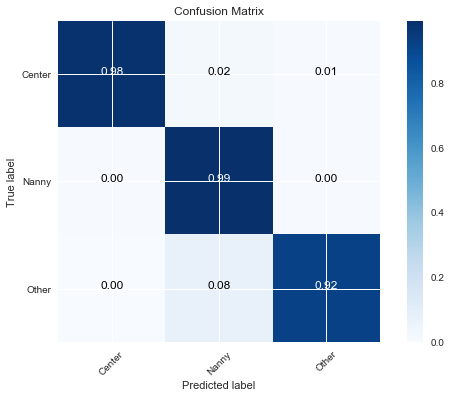

In [31]:
plot_confusion_matrix(cm_SVM, ['Center', 'Nanny', 'Other'], normalize = True)

In [32]:
scores_SVM = cross_val_score(trial_SVM, cl_data, cl_target, cv=5)

In [33]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_SVM.mean(), scores_SVM.std() * 2)) #accuracy conf int

Accuracy: 0.88 (+/- 0.04)


In [34]:
cv_SVM = cross_validation.ShuffleSplit(len(cl_data), n_iter=50,
                                   test_size=0.2, random_state=1)

CPU times: user 3.83 s, sys: 582 ms, total: 4.41 s
Wall time: 35.8 s


<module 'matplotlib.pyplot' from '/Users/MF/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

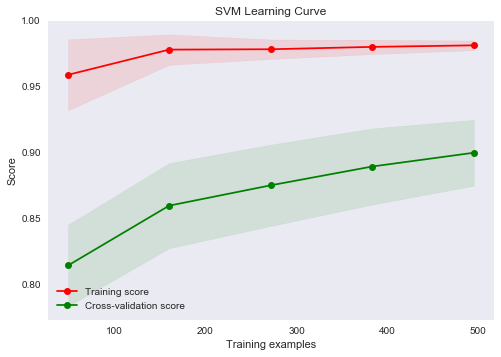

In [35]:
%%time
plot_learning_curve(trial_SVM, 'SVM Learning Curve', cl_data, cl_target, cv=cv_SVM, n_jobs=4)

## Classify Childcare posts into Legal, Known Illegal, and Unknown

In [36]:
len(cl_data)

619